In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pdb

## Load Data

In [2]:
data_raw = pd.read_csv('college_admissions.csv')

## Explore Data

In [5]:
data_raw[0:5]

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [6]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
admit    400 non-null int64
gre      400 non-null int64
gpa      400 non-null float64
rank     400 non-null int64
dtypes: float64(1), int64(3)
memory usage: 12.6 KB


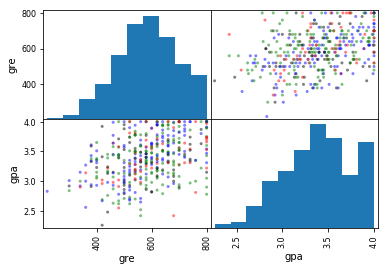

In [7]:
cmap = {1: 'red', 2:'green', 3:'blue', 4:'black'}
colors = data_raw['rank'].apply(lambda cc:cmap[cc])
pd.plotting.scatter_matrix(data_raw[['gre', 'gpa']], c=colors);

# Preprocess

In [29]:
# Create dummies
temp = pd.get_dummies(data_raw['rank'], prefix='rank')
data = pd.concat([data_raw, temp], axis=1)
data.drop(columns='rank', inplace=True)

# Normalize
for col in ['gre', 'gpa']:
    mean, std = data[col].mean(), data[col].std()
    # data.loc[:, col] = (data[col]-mean) / std
    data[col] = (data[col]-mean) / std

# Split off random 20% of the data for testing
np.random.seed(0)
sample = np.random.choice(data.index, size=int(len(data)*0.9), replace=False)
data, test_data = data.iloc[sample], data.drop(sample)

# Split into features and targets
features_train = data.drop('admit', axis=1)
targets_train =  data['admit']
features_test = test_data.drop('admit', axis=1)
targets_test = test_data['admit']

# Convert to numpy
x_train = features_train.values            # features train set (numpy)
y_train = targets_train.values[:,None]     # targets train set (numpy)
x_test = features_test.values              # features validation set (numpy)
y_test = targets_test.values[:,None]       # targets valudation set (numpy)

Confirm data scaled properly

In [30]:
x_train.shape

(360, 6)

In [31]:
assert x_train.ndim == 2 and x_train.shape[1] == 6            # 2d array, 6 input features
assert y_train.ndim == 2 and y_train.shape[1] == 1            # 2d array, 1 output

print('x_train means:', x_train.mean(axis=0).round(3))        # coumns 0,1 should be ~0.0
print('x_train stddev:', x_train.std(axis=0).round(3))        # coumns 0,1 should be ~1.0
print('x_train nonzero:', np.count_nonzero(x_train, axis=0))  # columns 2,3,4,5 (one-hot)

x_train means: [-0.005 -0.002  0.153  0.386  0.303  0.158]
x_train stddev: [1.006 1.    0.36  0.487 0.459 0.365]
x_train nonzero: [360 360  55 139 109  57]


In [32]:
x_test.shape

(40, 6)

In [33]:
print('x_test means:', x_test.mean(axis=0).round(3))        # coumns 0,1 should be ~0.0
print('x_test stddev:', x_test.std(axis=0).round(3))        # coumns 0,1 should be ~1.0
print('x_test nonzero:', np.count_nonzero(x_test, axis=0))  # columns 2,3,4,5 (one-hot)

x_test means: [0.042 0.021 0.15  0.3   0.3   0.25 ]
x_test stddev: [0.932 0.988 0.357 0.458 0.458 0.433]
x_test nonzero: [40 40  6 12 12 10]


## Do some backprop functions

In [17]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1-sigmoid(x))

def fwd(x, W):
    assert x.ndim == 2; assert W.ndim == 2
    
    z = x @ W
    y_hat = sigmoid(z)
    
    assert z.ndim == 2; assert y_hat.ndim == 2
    
    return y_hat, z



def backprop(x, y, W, lr):
    assert x.ndim == 2; assert y.ndim == 2; assert W.ndim == 2
    
    # Forward pass
    z = x @ W
    y_hat = sigmoid(z)
    
    # Backward pass
    ro = (y-y_hat) * -sigmoid_deriv(z)
    del_W = (x.T @ ro) / len(x)
    
    assert del_W.ndim == 2
    return del_W
    
    
def loss(x, y, W):
    assert x.ndim == 2; assert y.ndim == 2; assert W.ndim == 2
    
    y_hat = sigmoid(x @ W)
    
    assert y_hat.shape[1] == 1
    
    # no inner sum becouse single output
    return .5 * np.mean((y-y_hat)**2)
    
    
def ngrad(x, y, W):
    # Check gradient numerically
    eps = 1e-4
    del_W = np.zeros_like(W)    
    for r in range(W.shape[0]):
        for c in range(W.shape[1]):
            W_min = W.copy()
            W_pls = W.copy()
            
            W_min[r, c] -= eps
            W_pls[r, c] += eps
            
            l_pls = loss(x, y, W_pls)
            l_min = loss(x, y, W_min)

            del_W[r, c] = (l_pls - l_min) / (eps * 2)
    return del_W
        

## Training loop

Initialize neural net

In [38]:
np.random.seed(0)

n_inputs = x_train.shape[1]
n_outputs = y_train.shape[1]
W = np.random.normal(scale=n_inputs**-.5, size=[n_inputs, n_outputs])

Hyperparameters

In [39]:
nb_epochs = 2000
lr = 0.1

Main train loop

In [40]:
trace_loss_train = []
trace_loss_test = []
trace_acc_test = []

for e in range(nb_epochs):
    
    # Backprop
    dW = backprop(x_train, y_train, W, lr)
    W += -lr * dW
    
    # Train loss
    loss_train = loss(x_train, y_train, W)
    trace_loss_train.append(loss_train)        
    
    # if e % (nb_epochs / 10) == 0:
    loss_test = loss(x_test, y_test, W)
    trace_loss_test.append(loss_test)
    
    predictions, _ = fwd(x_test, W)
    predictions = predictions > 0.5
    acc_test = np.mean(predictions == y_test)
    trace_acc_test.append(acc_test)

    if e % (nb_epochs / 10) == 0:
        print('loss {0}, tacc {1:.3f}'.format(loss_train, acc_test))
    



loss 0.15224777536275844, tacc 0.475
loss 0.13015955315177377, tacc 0.475
loss 0.11435294270610373, tacc 0.500
loss 0.10585677810621827, tacc 0.600
loss 0.10191394554520483, tacc 0.675
loss 0.1000000143239566, tacc 0.700
loss 0.09898677097344712, tacc 0.725
loss 0.0984065319217976, tacc 0.750
loss 0.0980521765593448, tacc 0.750
loss 0.09782432184510809, tacc 0.750


**Correct output is:**
```
loss 0.15224777536275844, tacc 0.475
loss 0.13015955315177377, tacc 0.475
loss 0.11435294270610373, tacc 0.500
loss 0.10585677810621827, tacc 0.600
loss 0.10191394554520483, tacc 0.675
loss 0.1000000143239566, tacc 0.700
loss 0.09898677097344712, tacc 0.725
loss 0.0984065319217976, tacc 0.750
loss 0.0980521765593448, tacc 0.750
loss 0.09782432184510809, tacc 0.750
```

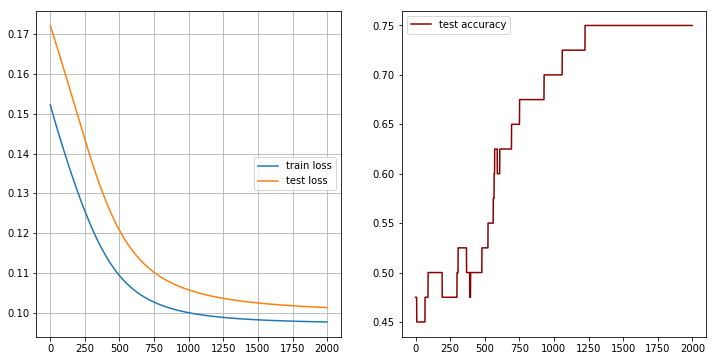

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12,6])
ax, ax2 = axes
ax.plot(trace_loss_train, label='train loss')
ax.plot(trace_loss_test, label='test loss')
ax.legend(loc='right')
ax.grid()
ax2.plot(trace_acc_test, color='darkred', label='test accuracy')
plt.legend()
plt.show()